# Experimental CNN Framework for Landsat Classification

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

from classifier_utilities import *

### importing datasets

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

l8_image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif'
                 ]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif'
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff'
]

landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))



In [3]:
# What is the raster's projection?
image_proj = landsat_datasets[0].crs # 4326
print('Image projection:')
print(image_proj)
print('---')
# What is the raster's projection?
label_proj = sentinel_datasets[0].crs
print('Labels projection:')
print(label_proj)
print('---')
# What is the raster's projection?
label_proj = dem_datasets[0].crs
print('Labels projection:')
print(label_proj)
print('---')
# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
---
Labels projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PAR

### Class Dictionary and Confusion Matrix Function

In [4]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

## Test out the generator and data prep functions

Let's make sure all this data prep actually works.

In [5]:
all_random_px = gen_pixel_locations(landsat_datasets[:1], 100000, 0, 11)

In [6]:
len(all_random_px[0])

100000

In [7]:
eval_generator = tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
                                label_dataset, 11, 11, all_random_px[0], batch_size=100000)

image_b, label_b = next(eval_generator)

In [8]:
image_b.shape

(100000, 11, 11, 10)

In [9]:
image_b[:,:,:,0:7].mean()

982.4954514521842

In [10]:
image_b[:,:,:,0:7].std()

1076.4081358422638

In [17]:
((image_b[:,:,:,0:7] - 982.5) / 1076.5).std()

0.9999146640429726

In [19]:
image_b[:,:,:,7:9].mean()

0.09912027174750683

In [20]:
image_b[:,:,:,7:9].std()

0.08702391609189894

In [25]:
((image_b[:,:,:,7:9] - 0.10) / 0.088).std()

0.988908137407942

In [26]:
image_b[:,:,:,9].mean()

31.870819596108273

In [27]:
image_b[:,:,:,9].std()

16.449048098707472

In [105]:
np.median(image_b[:,:,:,9])

30.96021270751953

In [29]:
((image_b[50000:50200,:,:,9] - 31) / 16.5).std()

1.1131584759160476

In [5]:
label_image = label_dataset.read()
label_image[label_image == 255] = 1
num_classes = len(np.unique(label_image))

label_image = merge_classes(label_image)

In [6]:
# generate the training and validation pixel locations

train_pixels = gen_balanced_pixel_locations(image_datasets=landsat_datasets[:1], train_count=50000, label_dataset=label_dataset)

all_labels = []
label_locations = []
for pixel in train_pixels:
    # row, col location in landsat
    r,c = pixel[0]
    ds_index = pixel[1]
    l8_proj = Proj(landsat_datasets[ds_index].crs)
    label_proj = Proj(label_dataset.crs)
    
    # geographic location in landsat
    x,y = landsat_datasets[ds_index].xy(r,c)
    # go from label projection into landsat projection
    x,y = transform(l8_proj, label_proj ,x,y)
    # get row and col location in label
    r,c = label_dataset.index(x,y)
    
    label_locations.append([r,c])
    
    # format (bands, height, width)
    all_labels.append(label_image[0,r,c])
    
label_locations = np.array(label_locations)

unique, counts = np.unique(np.array(all_labels), return_counts=True)
dict(zip(unique, counts))

100%|██████████| 1/1 [01:52<00:00, 112.16s/it]


{0: 1924,
 2: 1871,
 6: 1967,
 8: 1889,
 11: 2062,
 18: 1879,
 20: 1896,
 21: 1902,
 23: 198}

In [7]:
# print out some image and label batches and check out their shapes
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, 128, 128, train_pixels, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    #print('Label')
    #print(label)
    #print(label.shape)
    print('----')
    count += 1
    im_batch = im

Image
(10, 128, 128, 10)
----
Image
(10, 128, 128, 10)
----
Image
(10, 128, 128, 10)
----
Image
(10, 128, 128, 10)
----


### Visually inspect an image patch

While it shouldn't necessarily be recognizable it should look like it has data in it and that it varies somewhat from pixel to pixel.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


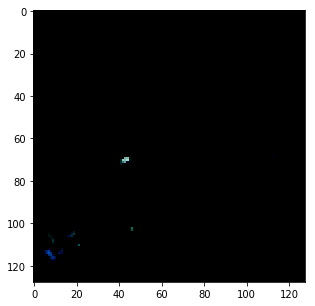

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 

axs.imshow(im_batch[7,:,:,1:4])

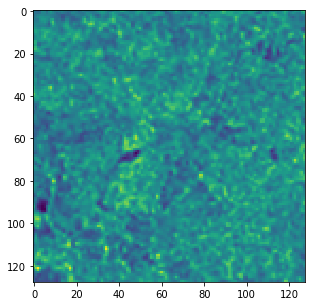

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 
axs.imshow(im_batch[7,:,:,8])

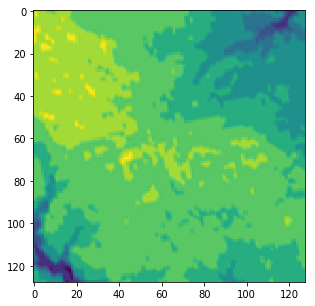

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 
axs.imshow(im_batch[7,:,:,9])

## Let's get to the CNN Development!!

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="2";

In [12]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, BatchNormalization


K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

### prep some of the hyperparameters

In [26]:
batch_size = 25
epochs = 200
num_classes = len(class_names)

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(64, 64, 10)


### build the model

This is just a simple CNN model but it should be able to perform well above random when predicting landcover types if everything is correct thus far.

In [40]:
model = Sequential()

model.add(Conv2D(32, (1, 1), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 32)        352       
_________________________________________________________________
batch_normalization_24 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_29 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_30 (Activation)   (None, 64, 64, 32)        0         
__________

In [ ]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))

#model.add(Conv2D(42, (3, 3)))
#model.add(BatchNormalization())
#model.add(Activation("relu"))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Conv2D(84, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

In [14]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        5824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 60, 60, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
__________

#### Future Models for Experimentation

In [24]:
from keras import regularizers
from keras.layers import Activation, BatchNormalization

weight_decay=1e-6

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 32)        2624      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
__________

#### Generate the train/validation pixel locations to train with

In [31]:
train_to_val_ratio = 0.7
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]

In [32]:
len(train_px)

10911

In [33]:
len(val_px)

4677

#### set up the remaining model hyperparameters and compile

In [41]:
sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

#### TRAIN THE MODEL!

In [ ]:
history = model.fit_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=100, verbose=1,
                    validation_data=tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/100
436/436 [==============================] - 53s 120ms/step - loss: 2.6137 - acc: 0.2509 - val_loss: 2.3134 - val_acc: 0.2128
Epoch 2/100
436/436 [==============================] - 46s 105ms/step - loss: 1.9400 - acc: 0.3448 - val_loss: 2.0452 - val_acc: 0.2355
Epoch 3/100
436/436 [==============================] - 46s 105ms/step - loss: 1.7288 - acc: 0.3706 - val_loss: 2.0826 - val_acc: 0.2301
Epoch 4/100
436/436 [==============================] - 46s 105ms/step - loss: 1.6281 - acc: 0.4056 - val_loss: 2.0330 - val_acc: 0.2639
Epoch 5/100
363/436 [=======================>......] - ETA: 4s - loss: 1.5675 - acc: 0.4186

In [35]:
history = model.fit_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=100, verbose=1,
                    validation_data=tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/100
436/436 [==============================] - 38s 88ms/step - loss: 2.6649 - acc: 0.2518 - val_loss: 2.4431 - val_acc: 0.1861
Epoch 2/100
436/436 [==============================] - 32s 73ms/step - loss: 1.9072 - acc: 0.3580 - val_loss: 2.0800 - val_acc: 0.2124
Epoch 3/100
436/436 [==============================] - 32s 73ms/step - loss: 1.7038 - acc: 0.3796 - val_loss: 2.0404 - val_acc: 0.2317
Epoch 4/100
436/436 [==============================] - 32s 74ms/step - loss: 1.6063 - acc: 0.4088 - val_loss: 2.0336 - val_acc: 0.2366
Epoch 5/100
436/436 [==============================] - 32s 73ms/step - loss: 1.5195 - acc: 0.4332 - val_loss: 1.8899 - val_acc: 0.2747
Epoch 6/100
436/436 [==============================] - 32s 72ms/step - loss: 1.4787 - acc: 0.4443 - val_loss: 1.9046 - val_acc: 0.2982
Epoch 7/100
436/436 [==============================] - 32s 73ms/step - loss: 1.4169 - acc: 0.4614 - val_loss: 1.7977 - val_acc: 0.3151
Epoch 8/100
436/436 [==============================] - 

436/436 [==============================] - 31s 72ms/step - loss: 0.3561 - acc: 0.8790 - val_loss: 1.4554 - val_acc: 0.4950
Epoch 62/100
436/436 [==============================] - 32s 73ms/step - loss: 0.3463 - acc: 0.8824 - val_loss: 1.6078 - val_acc: 0.4785
Epoch 63/100
436/436 [==============================] - 32s 73ms/step - loss: 0.3433 - acc: 0.8850 - val_loss: 1.5102 - val_acc: 0.4924
Epoch 64/100
436/436 [==============================] - 31s 72ms/step - loss: 0.3367 - acc: 0.8815 - val_loss: 1.5540 - val_acc: 0.4849
Epoch 65/100
436/436 [==============================] - 31s 72ms/step - loss: 0.3322 - acc: 0.8858 - val_loss: 1.4577 - val_acc: 0.4995
Epoch 66/100
436/436 [==============================] - 32s 74ms/step - loss: 0.3196 - acc: 0.8906 - val_loss: 1.5301 - val_acc: 0.4875
Epoch 67/100
407/436 [===========================>..] - ETA: 1s - loss: 0.3103 - acc: 0.8923

KeyboardInterrupt: 

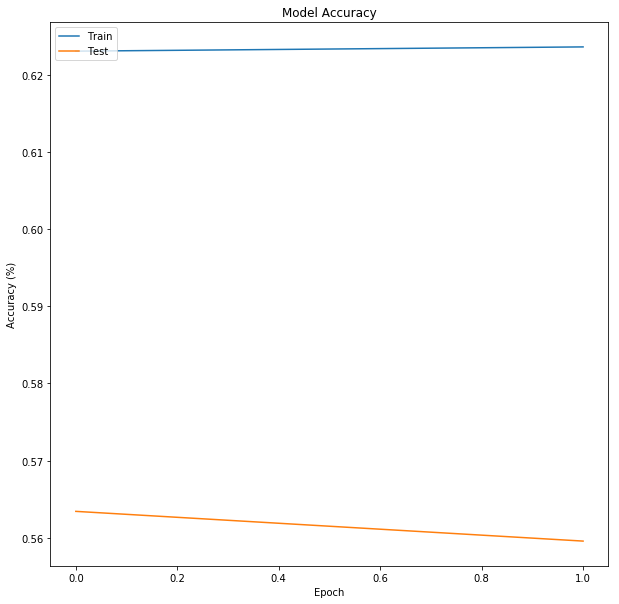

In [36]:
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

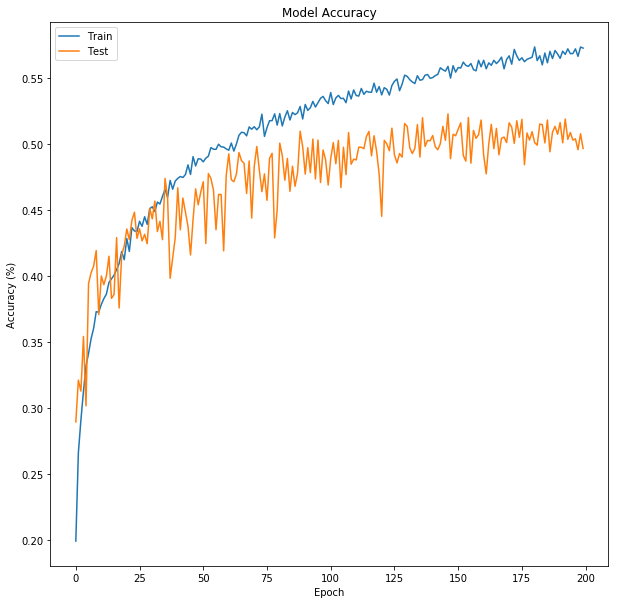

In [54]:
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### Now let's evaluate the Model

We'll just generate 500 test pixels to evaluate it on

Keras has a built in evaluate_generator function and because we told it above to use accuracy as a metric this function automatically outputs categorical accuracy which is what we want.

In [37]:
model.evaluate_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

187/187 [==============================] - 13s 71ms/step


[1.5007137566964257, 0.48598930295457177]

So in this simple model we're getting 37% accuracy across 23 classes which is well above the random accuracy which would be around 4% (aka 1/23). That means we're in business!

### Evaluating the model ourselves

If we wanted to run this evaluation and take a look at specific predictions and labels we can do that below (albeit more inefficiently) just to get an intuitive understanding of what is going wrong.

Now maybe more informatively let's build a confusion matrix using the scikit-learn function.

Read the docs here and make this more informative by following some of their examples: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

436/436 [==============================] - 28s 64ms/step


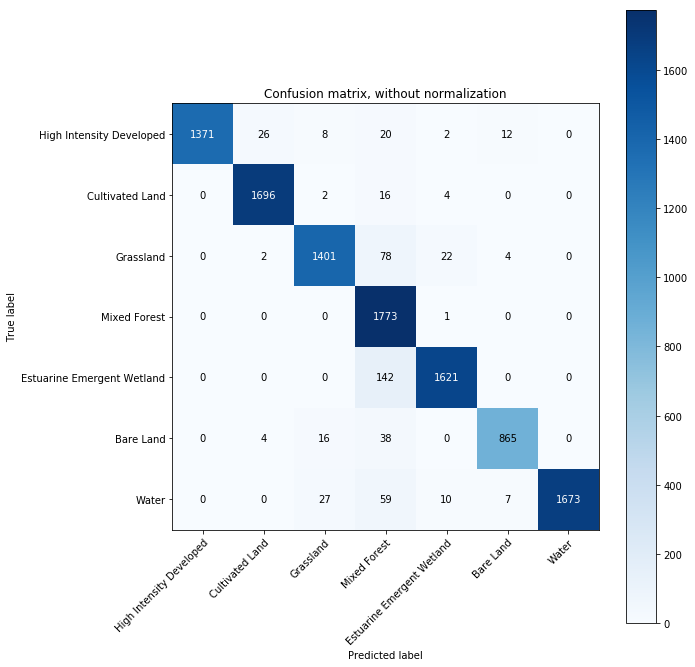

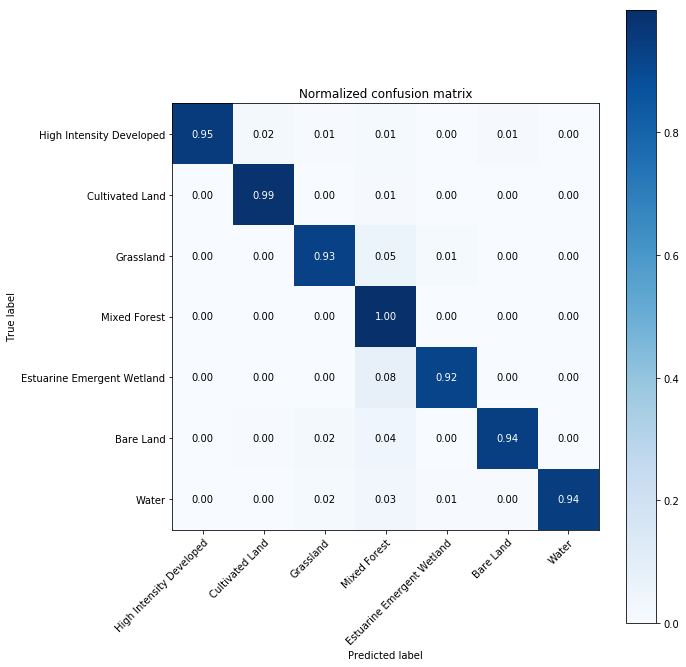

In [39]:
val_px = train_px
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
        label_dataset, tile_side, tile_side, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

eval_generator = tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
                                label_dataset, tile_side, tile_side, val_px, batch_size=1)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

208/208 [==============================] - 10s 49ms/step


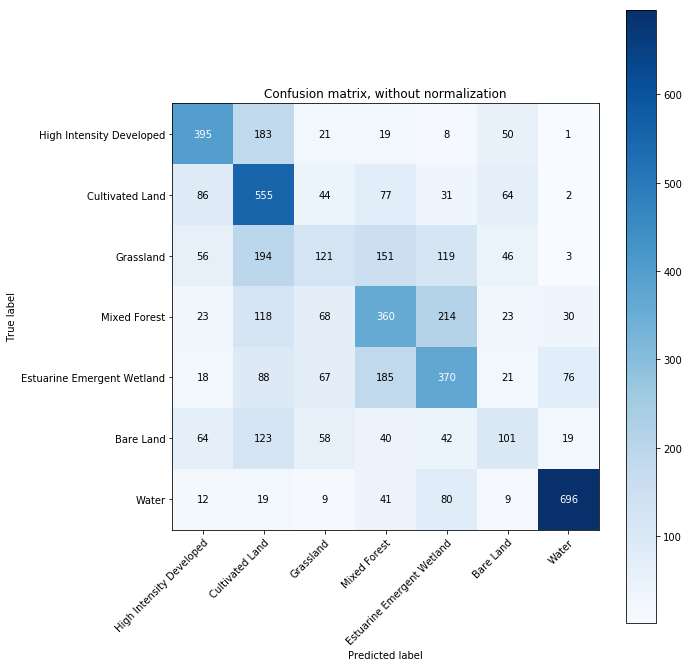

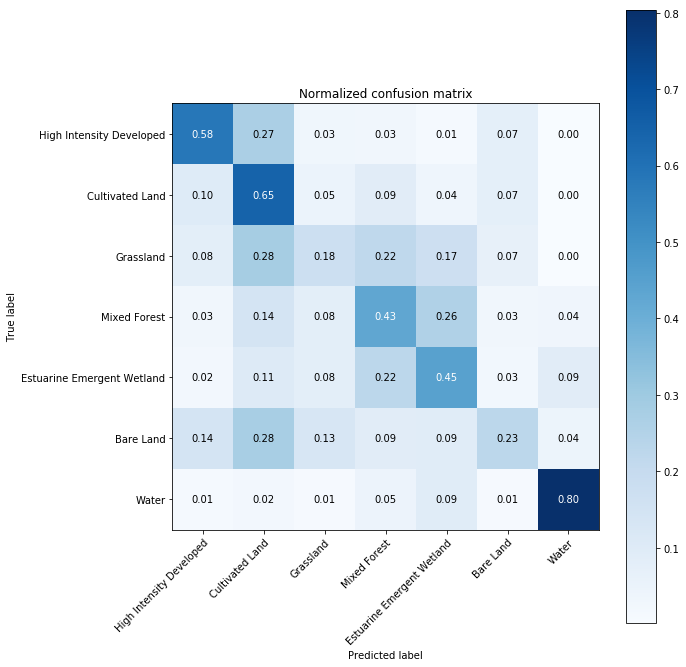

In [56]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
        label_dataset, tile_side, tile_side, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

eval_generator = tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
                                label_dataset, tile_side, tile_side, val_px, batch_size=1)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [57]:
unique, counts = np.unique(label_index, return_counts=True)
dict(zip(unique, counts))

{2: 677, 6: 859, 8: 690, 11: 836, 18: 825, 20: 447, 21: 866}

In [58]:
unique, counts = np.unique(pred_index, return_counts=True)
dict(zip(unique, counts))

{2: 654, 6: 1280, 8: 388, 11: 873, 18: 864, 20: 314, 21: 827}